In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Đường dẫn tới file CSV của dataset
file_path = '/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data.csv'

# Load dữ liệu
df = pd.read_csv(file_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [3]:
# Chuyển đổi trans_date_trans_time sang datetime và trích xuất giờ giao dịch
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour  # sử dụng .dt.hour để lấy số giờ
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())

# Tính delta_t theo từng người dùng (cc_num)
df = df.sort_values(by=['cc_num', 'trans_date_trans_time_numeric'])
df['delta_t'] = df.groupby('cc_num')['trans_date_trans_time_numeric'].diff().fillna(0)
df['delta_t'] = df['delta_t'].clip(upper=1e5)  # cắt giá trị lớn bất thường nếu cần
df['log_delta_t'] = np.log1p(df['delta_t'])

# Phân loại khoảng thời gian thành nhóm
df['delta_t_category'] = pd.cut(df['delta_t'], bins=[-1, 60, 600, 3600, 21600, 86400, 1e6],
                                labels=['<1min', '1-10min', '10-60min', '1-6h', '6-24h', '>1day'])
df['delta_t_cat_num'] = df['delta_t_category'].cat.codes

# Chuyển đổi dob sang datetime và tính tuổi (dựa trên năm 2021)
df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = 2021 - df['dob'].dt.year

# Tạo nhóm tuổi dựa trên cust_age
df['cust_age_groups'] = df['cust_age'].apply(lambda x: 'below 10' if x < 10 else (
    '10-20' if 10 <= x < 20 else (
    '20-30' if 20 <= x < 30 else (
    '30-40' if 30 <= x < 40 else (
    '40-50' if 40 <= x < 50 else (
    '50-60' if 50 <= x < 60 else (
    '60-70' if 60 <= x < 70 else (
    '70-80' if 70 <= x < 80 else 'Above 80'))))))))
    
# Sử dụng pivot table để tính giá trị trung bình của amt theo cust_age_groups và is_fraud
age_piv_2 = pd.pivot_table(data=df,
                           index='cust_age_groups',
                           columns='is_fraud',
                           values='amt',
                           aggfunc=np.mean)
age_piv_2.sort_values(by=1, ascending=True, inplace=True)
age_dic = {k: v for (k, v) in zip(age_piv_2.index.values, age_piv_2.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_dic)

# --- Xử lý các biến categorical khác ---
# Ánh xạ biến category (dựa trên giao dịch gian lận)
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=True)
merch_cat_dic = {k: v for (k, v) in zip(merch_cat.index.values, merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_dic)

# Ánh xạ biến job
job_txn_piv_2 = pd.pivot_table(data=df,
                               index='job',
                               columns='is_fraud',
                               values='amt',
                               aggfunc=np.mean)
job_cat_dic = {k: v for (k, v) in zip(job_txn_piv_2.index.values, job_txn_piv_2.reset_index().index.values)}
df['job'] = df['job'].map(job_cat_dic)

# --- Chuẩn hóa và mã hóa các biến ---
# Chuyển trans_hour thành số nguyên (nếu chưa)
df['trans_hour'] = df['trans_hour'].astype(int)

# Mã hóa biến gender thành các biến nhị phân
df = pd.get_dummies(data=df, columns=['gender'], drop_first=True, dtype='int')

# Các cột cần chuyển: merchant, first, last, street, city, state, zip
cols_to_encode = ['merchant', 'first', 'last', 'street', 'city', 'state', 'zip']
for col in cols_to_encode:
    df[col + '_num'] = pd.factorize(df[col])[0]

/tmp/ipykernel_522273/207530129.py:32: FutureWarning: The provided callable <function mean at 0x7ac3781b5750> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  age_piv_2 = pd.pivot_table(data=df,
/tmp/ipykernel_522273/207530129.py:48: FutureWarning: The provided callable <function mean at 0x7ac3781b5750> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  job_txn_piv_2 = pd.pivot_table(data=df,


In [4]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Nếu cần, loại bỏ một số cột định danh không muốn tính (ví dụ: trans_date_trans_time)
if 'trans_date_trans_time' in numeric_features:
    numeric_features.remove('trans_date_trans_time')

# Tính ma trận tương quan
corr_matrix = df[numeric_features].corr()

# Lấy hệ số tương quan giữa các feature với nhãn is_fraud
corr_with_label = corr_matrix['is_fraud'].drop('is_fraud')

# Sắp xếp theo độ tương quan tuyệt đối tăng dần (các feature có tương quan thấp nhất)
lowest_corr = corr_with_label.abs().sort_values(ascending=True)
lowest_corr_df = lowest_corr.reset_index()
lowest_corr_df.columns = ['Feature', 'Correlation_with_is_fraud']

# Sắp xếp theo độ tương quan tuyệt đối giảm dần (các feature có tương quan cao nhất)
highest_corr = corr_with_label.abs().sort_values(ascending=False)
highest_corr_df = highest_corr.reset_index()
highest_corr_df.columns = ['Feature', 'Correlation_with_is_fraud']

print("Các feature có độ tương quan thấp nhất với is_fraud:")
print(lowest_corr_df)

print("\nCác feature có độ tương quan cao nhất với is_fraud:")
print(highest_corr_df)

Các feature có độ tương quan thấp nhất với is_fraud:
                          Feature  Correlation_with_is_fraud
0                        city_pop                   0.000325
1                      Unnamed: 0                   0.000524
2                      merch_long                   0.000999
3                            long                   0.001022
4                          cc_num                   0.001125
5                         zip_num                   0.001189
6                             job                   0.001388
7                       state_num                   0.001414
8                      street_num                   0.001452
9                    merchant_num                   0.001683
10                       city_num                   0.001876
11                       last_num                   0.002183
12                            zip                   0.002190
13                      merch_lat                   0.002778
14                      first_nu

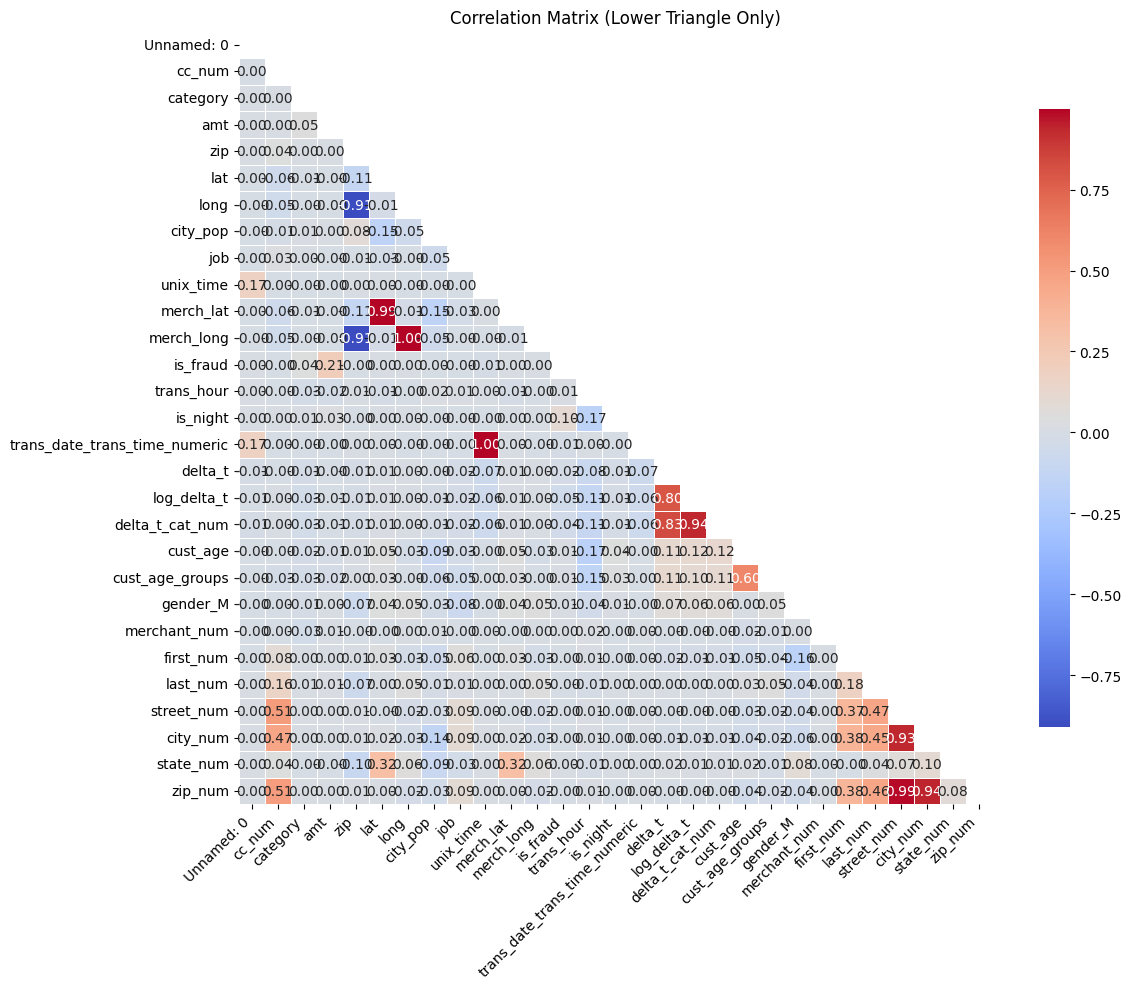

In [5]:
# Tạo mask để chỉ hiển thị tam giác dưới (dưới đường chéo chính)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,           # Ẩn tam giác trên
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title("Correlation Matrix (Lower Triangle Only)")
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X cho dễ đọc
plt.tight_layout()
plt.show()

In [9]:
output_path = '/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data_with_deltat.csv'
df.to_csv(output_path, index=False)
print(f"✅ Dataset đã lưu thành công tại: {output_path}")

✅ Dataset đã lưu thành công tại: /home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data_with_deltat.csv
